# Linear Regression Modeling of King County Real Estate Sale Prices
<b>Authors:</b> Aisha Baitemirova-Othman, Angela Kim, Steven Addison, Wahaj Dar
\
<b>Instructor:</b> David Elliott
----

## Overview
This project analyzes residential real estate sales in King County, Washington, and uses the data to create a model that predicts price based on the parameters given.

## Business Problem
Windermere Real Estate, based in Seattle, Washington, wants to better serve home buyers by being able to accurately present a price point using features of a house (ie. number of bedrooms) that buyers are looking for.

## Data Understanding
This dataset contains information about residential real estate sales in King County between May 2014 - May 2015. It includes details such as number of bedrooms and bathrooms, square footage of the home, and various features regarding location.

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

!pip install geopy
import geopy
from geopy import distance
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

> Here we import our data and skim the first five rows to get a general idea of what the dataframe looks like. We also get an initial look at missing values and datatypes that need to be converted.

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
display(df.head())
display(df.info())

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0      5650     1.0        NaN  NONE  ...      7 Average       1180   
1      7242     2.0         NO  NONE  ...      7 Average       2170   
2     10000     1.0         NO  NONE  ...  6 Low Average        770   
3      5000     1.0         NO  NONE  ...      7 Average       1050   
4      8080     1.0         NO  NONE  ...         8 Good       1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

> Cleaning & preparing the data.

In [3]:
# Drop the 'id' and 'date' columns
# Fill in missing data
# Convert all object datatype columns to numeric

df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['waterfront'] = df['waterfront'].fillna('NO')
df['waterfront'] = df['waterfront'].str.replace('NO', '0')
df['waterfront'] = df['waterfront'].str.replace('YES', '1')
df['waterfront'] = pd.to_numeric(df['waterfront'])
df['view'] = df['view'].fillna('NONE')
df['grade'] = df['grade'].str.replace('7 Average', '7')
df['grade'] = df['grade'].str.replace('8 Good', '8')
df['grade'] = df['grade'].str.replace('9 Better', '9')
df['grade'] = df['grade'].str.replace('6 Low Average', '6')
df['grade'] = df['grade'].str.replace('10 Very Good', '10')
df['grade'] = df['grade'].str.replace('11 Excellent', '11')
df['grade'] = df['grade'].str.replace('5 Fair', '5')
df['grade'] = df['grade'].str.replace('12 Luxury', '12')
df['grade'] = df['grade'].str.replace('4 Low', '4')
df['grade'] = df['grade'].str.replace('13 Mansion', '13')
df['grade'] = df['grade'].str.replace('3 Poor', '3')
df['grade'] = pd.to_numeric(df['grade'])
if [df[df['sqft_basement'] == '?']]:
    df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['bedrooms'].replace(33, 3, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['yr_sold'] = df['date'].dt.year
df['house_age'] = df['yr_sold'] - df['yr_built']
df.drop(labels=['id', 'date'], axis=1, inplace=True)

In [4]:
# One-hot encoding 'condition' and 'view' columns

condition = df[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(condition)
condition_enc = ohe.transform(condition)
condition_enc = pd.DataFrame(condition_enc,
                             columns=['cond_avg','cond_fair','cond_good','cond_poor','cond_verygood'],
                             index=df.index)
df.drop('condition', axis=1, inplace=True)
df = pd.concat([df, condition_enc], axis=1)

view = df[['view']]
ohe.fit(view)
view_enc = ohe.transform(view)
view_enc = pd.DataFrame(view_enc,
                        columns=['view_avg','view_excellent','view_fair','view_good','view_none'],
                        index=df.index)
df.drop('view', axis=1, inplace=True)
df = pd.concat([df, view_enc], axis=1)

In [5]:
# Create 'distance_from_bellevue' column

bellevue = (47.601, -122.2015)

def distancer(row):
    coords_1 = bellevue
    coords_2 = (row['lat'], row['long'])
    return geopy.distance.distance(coords_1, coords_2).miles

df['distance_from_bellevue'] = df.apply(distancer, axis=1)

# Plot distance map

distancemap = df[df['price'] <= 1000000] 
fig = px.scatter_mapbox(data_frame = distancemap, lat='lat', lon='long', color='price')
fig.update_geos(resolution=50)
fig.update_layout(mapbox_style="carto-darkmatter")

In [6]:
# Examine correlations

corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='RdBu', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

| 'sqft_living' has the highest correlation with 'price' at 0.70. We also see high multicollinearity.

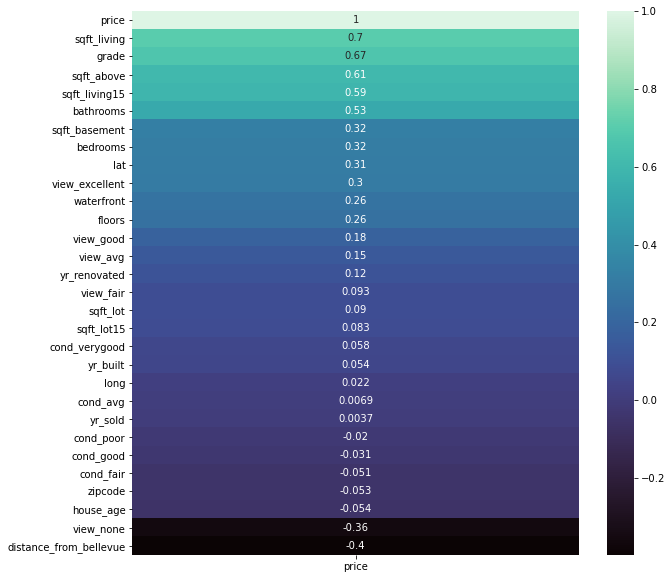

In [7]:
ix = df.corr().sort_values('price', ascending=False).index
df_sorted = df.loc[:, ix]

plt.figure(figsize=(10,10))
sns.heatmap(df_sorted.corr()[['price']],
            cmap="mako",
            annot=True);

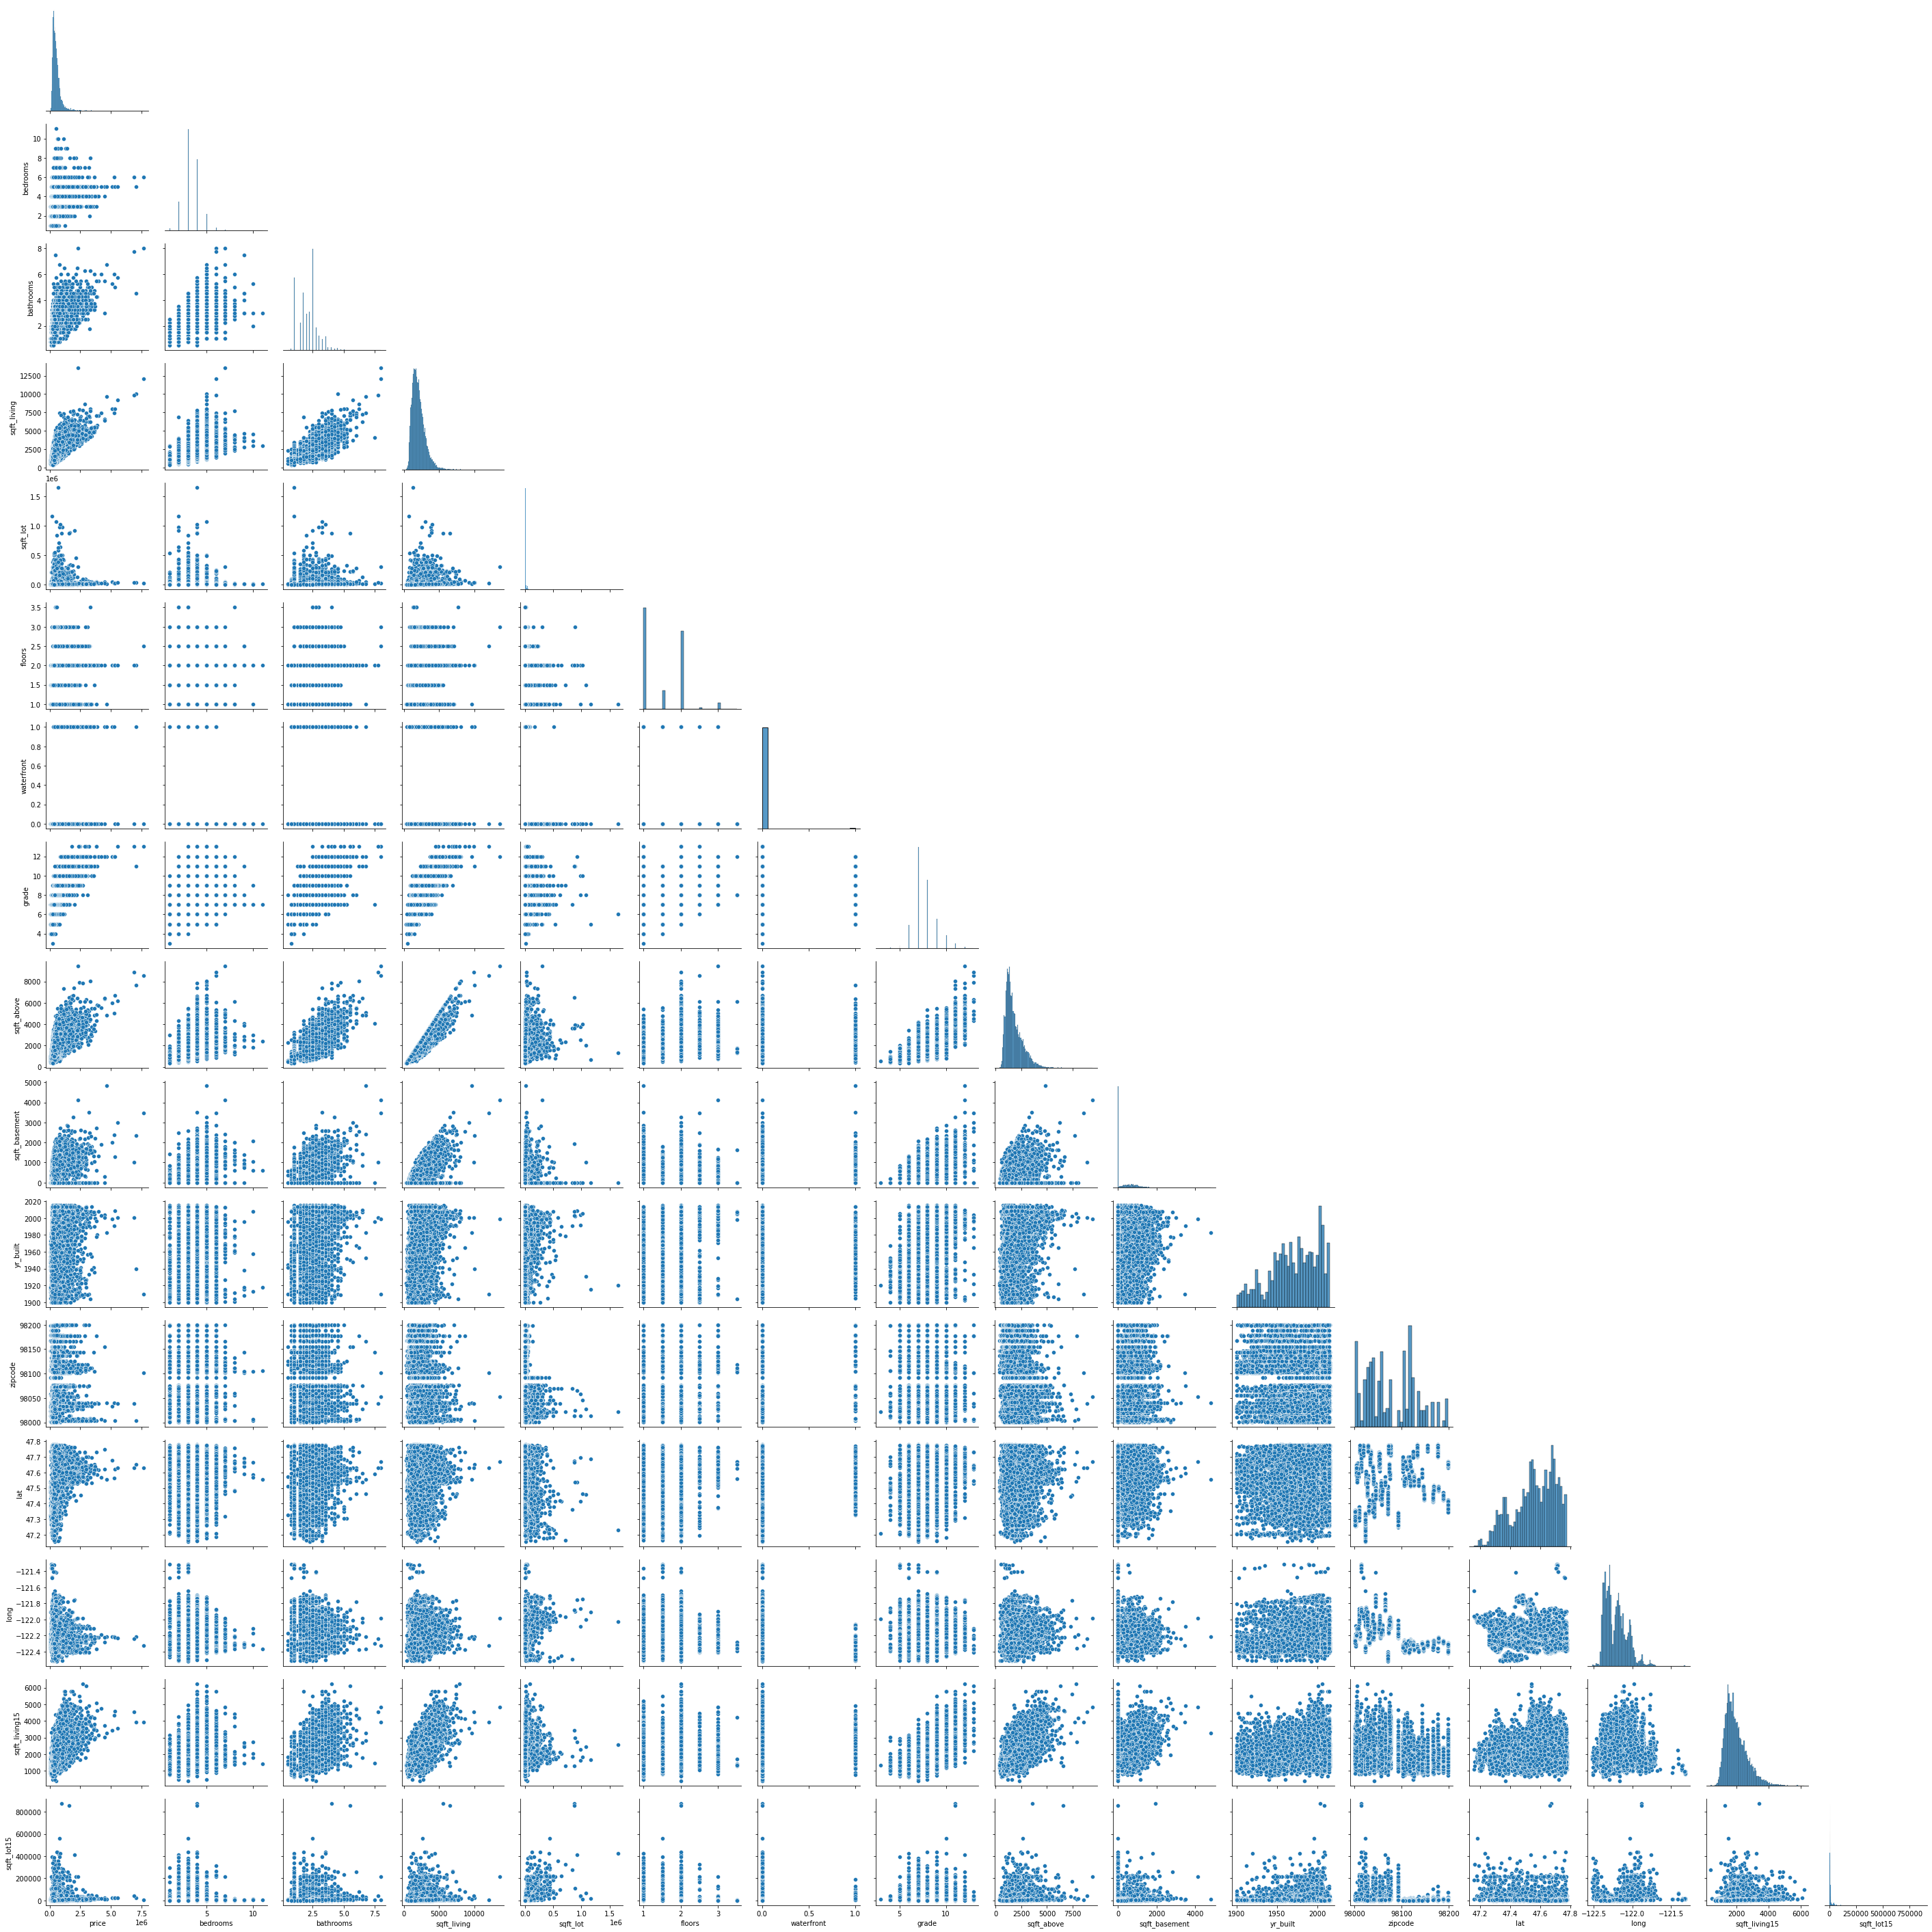

In [8]:
# Scatter matrix

scatter_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
                   'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15','sqft_lot15']

df_scatter = df[scatter_columns]

sns.pairplot(df_scatter, corner=True);

> Scatter matrix shows many non-normal distributions.

## Inferential Modeling

In [9]:
# Analyzing OLS results

outcome = 'price'
dfx = df.drop('price', axis=1)
predictors = '+'.join(dfx.columns)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     2270.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:10:50   Log-Likelihood:            -2.9347e+05
No. Observations:               21597   AIC:                         5.870e+05
Df Residuals:                   21571   BIC:                         5.872e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.869e+07   4.53e+06     -6.328      0.000   -3.76e+07   -1.98e+07
bedrooms               -4.093e+04   1899.880    -21.544      0.000   -4.47e+04   -3.72e+04
bathrooms               4.038e+04   3139.238     12.864      0.000    3.42e+04    4.65e+04
sqft_living              111.5017      2.194     50.811      0.000     107.200     115.803
sqft_lot                   0.2136      0.046      4.639      0.000       0.123       0.304
floors                  2372.2405   3463.560      0.685      0.493   -4416.592    9161.073
waterfront              5.355e+05   1.96e+04     27.378      0.000    4.97e+05    5.74e+05
grade                   8.844e+04   2087.403     42.369      0.000    8.43e+04    9.25e+04
sqft_above                78.3929      2.171     36.108      0.000      74.137      82.648
sqft_basement             33.1190      2.548     12.999      0.000      28.125      38.113
yr_built                8639.5763    939.648      9.194      0.000    6797.797    1.05e+04
yr_renovated              24.9298      3.824      6.520      0.000      17.435      32.425
zipcode                 -507.6069     31.836    -15.944      0.000    -570.008    -445.206
lat                     3.072e+05   1.26e+04     24.379      0.000    2.83e+05    3.32e+05
long                   -1.492e+05   1.27e+04    -11.719      0.000   -1.74e+05   -1.24e+05
sqft_living15              8.8410      3.328      2.656      0.008       2.318      15.364
sqft_lot15                -0.1242      0.071     -1.759      0.079      -0.263       0.014
yr_sold                 1.954e+04   1877.232     10.410      0.000    1.59e+04    2.32e+04
house_age                1.09e+04    938.899     11.611      0.000    9061.481    1.27e+04
cond_avg               -5.748e+06   9.07e+05     -6.337      0.000   -7.53e+06   -3.97e+06
cond_fair              -5.746e+06   9.07e+05     -6.334      0.000   -7.52e+06   -3.97e+06
cond_good              -5.725e+06   9.07e+05     -6.314      0.000    -7.5e+06   -3.95e+06
cond_poor              -5.785e+06   9.07e+05     -6.376      0.000   -7.56e+06   -4.01e+06
cond_verygood          -5.686e+06   9.07e+05     -6.272      0.000   -7.46e+06   -3.91e+06
view_avg               -5.792e+06   9.07e+05     -6.387      0.000   -7.57e+06   -4.01e+06
view_excellent         -5.552e+06   9.07e+05     -6.121      0.000   -7.33e+06   -3.77e+06
view_fair              -5.765e+06   9.07e+05     -6.356      0.000   -7.54e+06   -3.99e+06
view_good              -5.714e+06   9.07e+05     -6.300      0.000   -7.49e+06   -3.94e+06
view_none              -5.867e+06   9.07e+05     -6.472      0.000   -7.64e+06   -4.09e+06
distance_from_bellevue -1.331e+04    328.984    -40.459      0.000    -1.4e+04   -1.27e+04
==============================================================================
O

> The p-values for 'floors' and 'sqft_lot15' are not statistically significant. JB is very high, indicating non-normal distributions. There is strong multicollinearity.

> Previously, we saw that 'price' and 'sqft_living' have the strongest correlation, but the scatter matrix reveals that they are not normally distributed.

In [10]:
# OLS between 'price' and 'sqft_living'
f = 'price~sqft_living'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:10:51   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

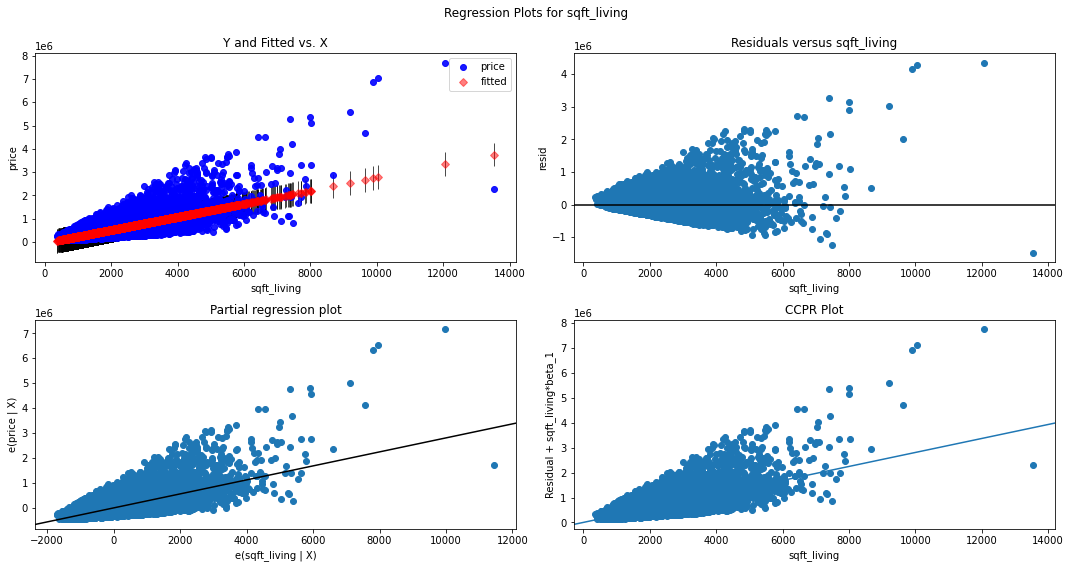

In [11]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig);

> Plots show heteroscedasticity.

In [12]:
f = 'price~distance_from_bellevue'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4062.
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:10:55   Log-Likelihood:            -3.0553e+05
No. Observations:               21597   AIC:                         6.111e+05
Df Residuals:                   21595   BIC:                         6.111e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.254e+05   5026.642    164.200      0.000    8.16e+05    8.35e+05
distance_from_bellevue -2.677e+04    420.035    -63.734      0.000   -2.76e+04   -2.59e+04
==============================================================================
Omnibus:                    20006.141   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1572480.456
Skew:                           4.233   Prob(JB):                         0.00
Kurtosis:                      43.936   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

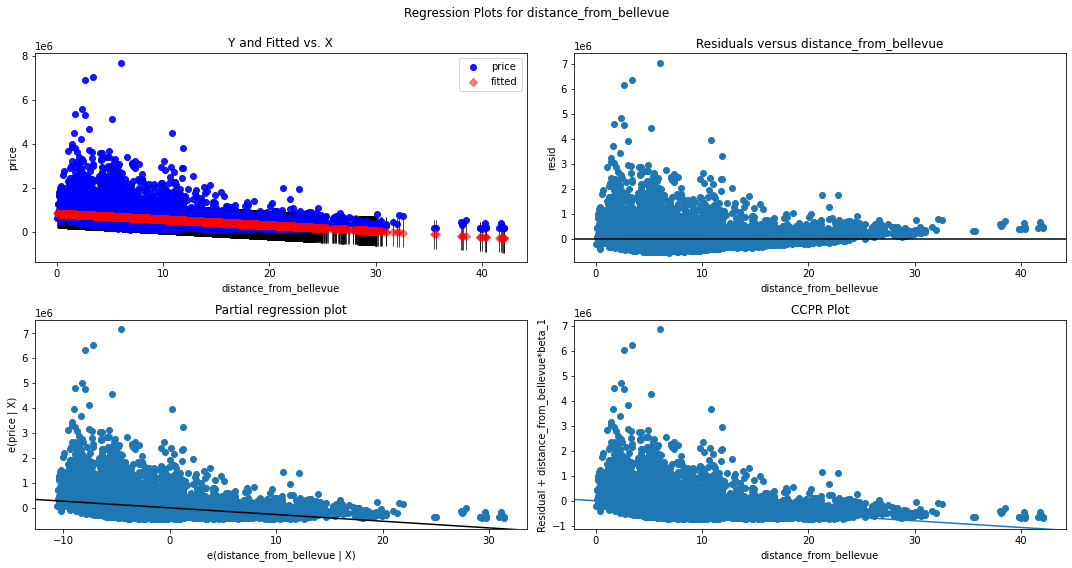

In [13]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "distance_from_bellevue", fig=fig)
plt.show()

In [14]:
# Normalizing distribution using log transformation

df0 = df.copy()
df0['price_log'] = np.log(df0['price'])
df0['sqft_living_log'] = np.log(df0['sqft_living'])
df0 = df0.drop(['price', 'sqft_living'], axis=1)

# OLS between 'price_log' and 'sqft_living_log'

f = 'price_log~sqft_living_log'
model = ols(f, df0).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                        15:11:01   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living_log     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

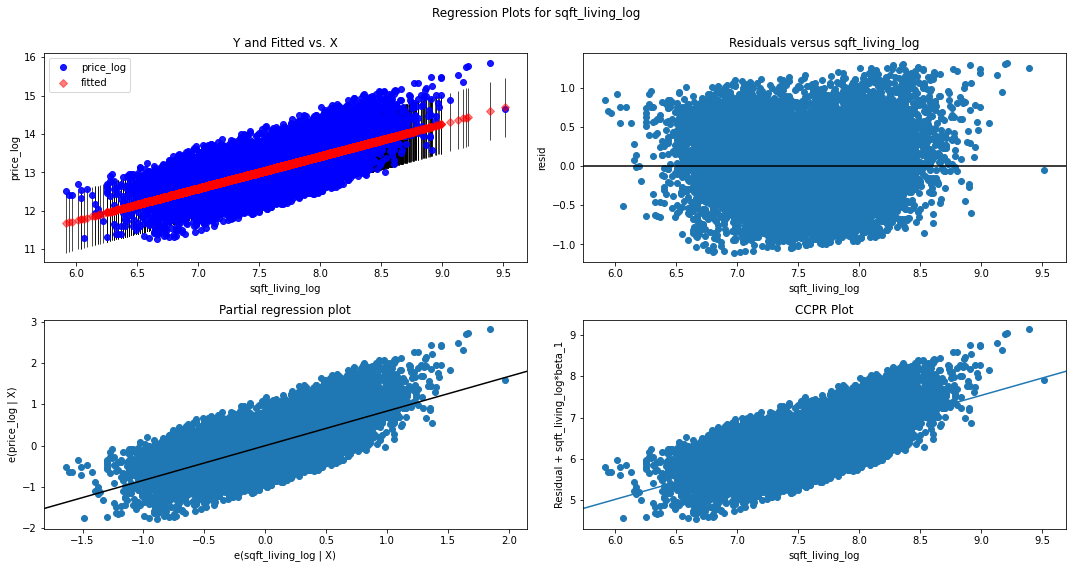

In [15]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living_log', fig=fig);

| When 'price' and 'sqft_living' undergo log transformation, they are more normally distributed and more homoscedastic, making them better for modeling.

## Predictive Modeling

<b>Baseline Model & First Simple Linear Regression Model</b>

Baseline Train R²: 0.0
Baseline Test R²: -3.1441572518886574e-06

Simple LR Model Train R²: 0.45511314986053364
Simple LR Model Test R² 0.45607988572902736

LR1 R²: 0.45511314986053364
LR1 Train Mean Squared Error: 0.1510898776130387
LR1 Test Mean Squared Error: 0.1507354170701051


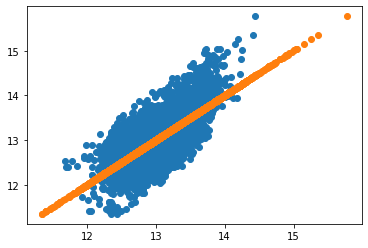

In [16]:
# df0 has original price & sqft_living removed, has price_log & sqft_living_log
X = df0[['sqft_living_log']]
y = df0[['price_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

# baseline
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
print('Baseline Train R\u00b2:', baseline.score(X_train, y_train))
print('Baseline Test R\u00b2:', baseline.score(X_test, y_test))
print()

# simple lr
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple LR Model Train R\u00b2:', lr.score(X_train, y_train))
print('Simple LR Model Test R\u00b2', lr.score(X_test, y_test))
print()
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('LR1 R\u00b2:', lr.score(X_train, y_train))
print('LR1 Train Mean Squared Error:', train_mse)
print('LR1 Test Mean Squared Error:', test_mse)
y_test_pred = lr.predict(X_test)
plt.scatter(y_test_pred, y_test)
plt.scatter(y_test, y_test);

<b>First Multiple Linear Regression Model</b>
\
Model with all untouched predictor variables.

LR1 R²: 0.7225969246645305
LR1 Train Mean Squared Error: 38257931157.788956
LR1 Test Mean Squared Error: 34034211801.90261


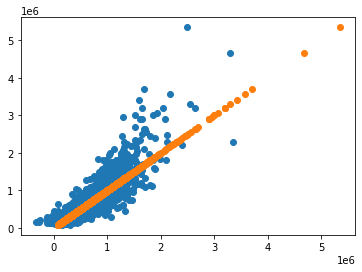

In [17]:
# df1 = original df
df1 = df.copy()
X1 = df1.drop(['price'], axis=1)
y1 = df1[['price']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
y1_hat_train = lr1.predict(X1_train)
y1_hat_test = lr1.predict(X1_test)
train1_mse = mean_squared_error(y1_train, y1_hat_train)
test1_mse = mean_squared_error(y1_test, y1_hat_test)
print('LR1 R\u00b2:', lr1.score(X1_train, y1_train))
print('LR1 Train Mean Squared Error:', train1_mse)
print('LR1 Test Mean Squared Error:', test1_mse)
y1_test_pred = lr1.predict(X1_test)
plt.scatter(y1_test_pred, y1_test)
plt.scatter(y1_test, y1_test);

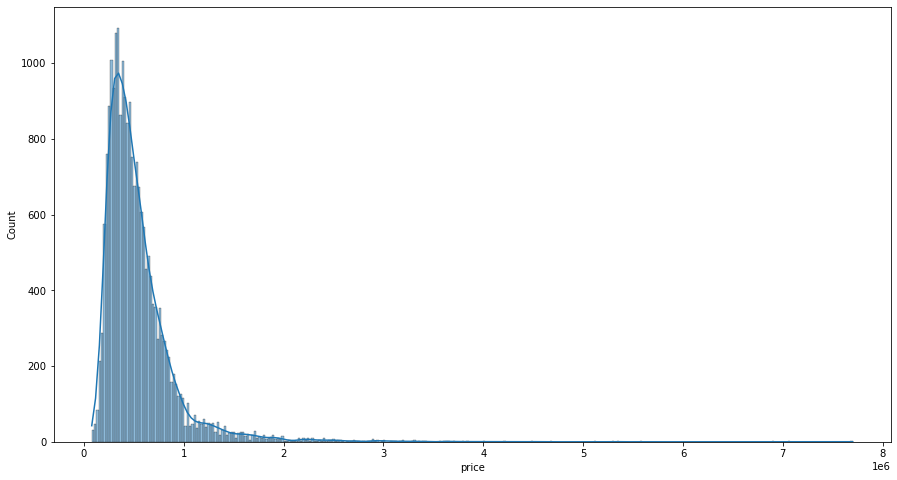

In [18]:
plt.figure(figsize = (15,8))
sns.histplot(df['price'], kde=True);

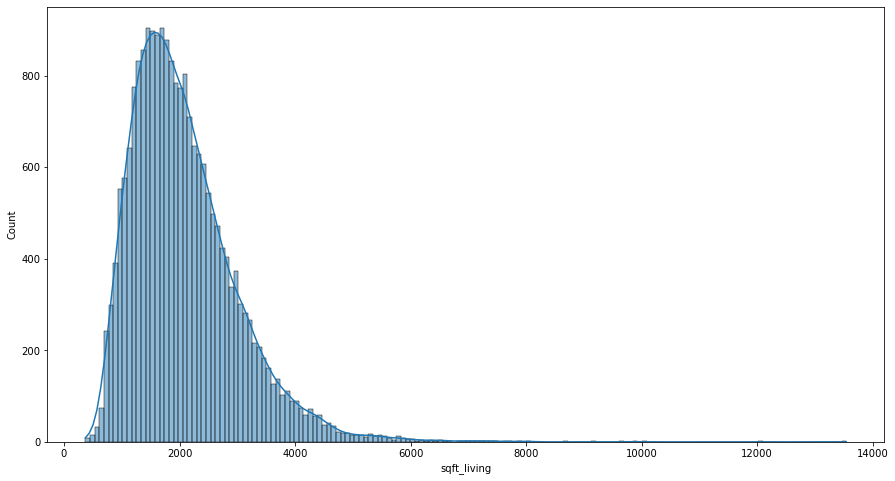

In [19]:
plt.figure(figsize = (15,8))
sns.histplot(df['sqft_living'], kde=True);

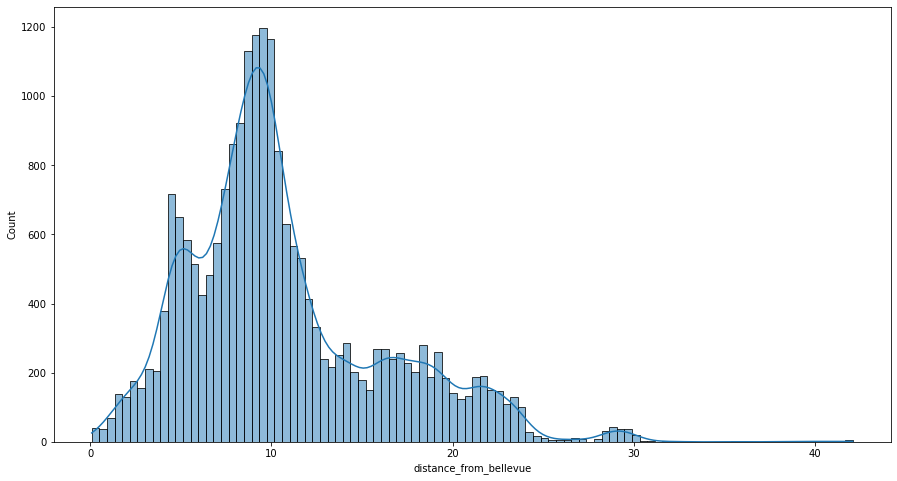

In [20]:
plt.figure(figsize = (15,8))
sns.histplot(df['distance_from_bellevue'], kde=True);

<b>Second Multiple Linear Regression Model</b>
\
Model with price, sqft_living, and distance_from_bellevue outliers removed.

In [21]:
price_low = df1["price"].quantile(0.023)
price_hi  = df1["price"].quantile(0.977)
df2 = df1[(df1["price"] < price_hi) & (df1["price"] > price_low)]
sqft_low = df2['sqft_living'].quantile(0.023)
sqft_hi  = df2['sqft_living'].quantile(0.977)
df2 = df2[(df2['sqft_living'] < sqft_hi) & (df2['sqft_living'] > sqft_low)]
distance_low = df2['distance_from_bellevue'].quantile(0.023)
distance_hi  = df2['distance_from_bellevue'].quantile(0.977)
df2 = df2[(df2['distance_from_bellevue'] < distance_hi) & (df2['distance_from_bellevue'] > distance_low)]

LR2 R²: 0.7202156040231042
LR2 Train Mean Squared Error: 14399425171.759562
LR2 Test Mean Squared Error: 14579756051.437109


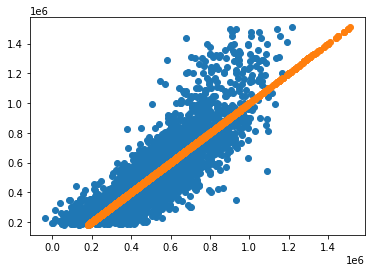

In [22]:
X2 = df2.drop(['price'], axis=1)
y2 = df2[['price']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
y2_hat_train = lr2.predict(X2_train)
y2_hat_test = lr2.predict(X2_test)
train2_mse = mean_squared_error(y2_train, y2_hat_train)
test2_mse = mean_squared_error(y2_test, y2_hat_test)
print('LR2 R\u00b2:', lr2.score(X2_train, y2_train))
print('LR2 Train Mean Squared Error:', train2_mse)
print('LR2 Test Mean Squared Error:', test2_mse)
y2_test_pred = lr2.predict(X2_test)
plt.scatter(y2_test_pred, y2_test)
plt.scatter(y2_test, y2_test);

<b>Third Multiple Linear Regression Model</b>
\
Second model with log transformed price, sqft_living, and distance_from_bellevue.

In [23]:
df3 = df2.copy()
df3['price_log'] = np.log(df2['price'])
df3['sqft_living_log'] = np.log(df3['sqft_living'])
df3['distance_from_bellevue_log'] = np.log(df3['distance_from_bellevue'])
df3 = df3.drop(['price', 'sqft_living', 'distance_from_bellevue'], axis=1)

LR3 R²: 0.7624338571937116
LR3 Train Mean Squared Error: 0.043900609523814534
LR3 Test Mean Squared Error: 0.043306394141288895


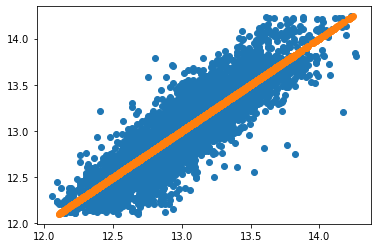

In [24]:
X3 = df3.drop(['price_log'], axis=1)
y3 = df3[['price_log']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)
y3_hat_train = lr3.predict(X3_train)
y3_hat_test = lr3.predict(X3_test)
train3_mse = mean_squared_error(y3_train, y3_hat_train)
test3_mse = mean_squared_error(y3_test, y3_hat_test)
print('LR3 R\u00b2:', lr3.score(X3_train, y3_train))
print('LR3 Train Mean Squared Error:', train3_mse)
print('LR3 Test Mean Squared Error:', test3_mse)
y3_test_pred = lr3.predict(X3_test)
plt.scatter(y3_test_pred, y3_test)
plt.scatter(y3_test, y3_test);

<b>Fourth Multiple Linear Regression Model</b>
\
Third model with several predictor variables removed.

In [25]:
df4 = df3[['price_log', 'sqft_living_log', 'distance_from_bellevue_log', 'bedrooms', 'sqft_lot',
         'floors', 'waterfront', 'sqft_basement', 'yr_renovated', 'house_age', 'view_none']]

LR4 R²: 0.6202468570293977
LR4 Train Mean Squared Error: 0.07062364476242482
LR4 Test Mean Squared Error: 0.07243899357548968


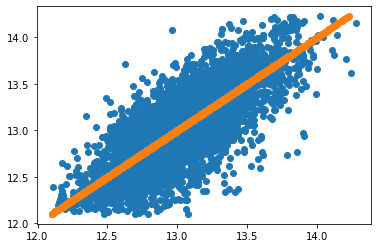

In [26]:
X4 = df4.drop(['price_log'], axis=1)
y4 = df4[['price_log']]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4)
lr4 = LinearRegression()
lr4.fit(X4_train, y4_train)
y4_hat_train = lr4.predict(X4_train)
y4_hat_test = lr4.predict(X4_test)
train4_mse = mean_squared_error(y4_train, y4_hat_train)
test4_mse = mean_squared_error(y4_test, y4_hat_test)
print('LR4 R\u00b2:', lr4.score(X4_train, y4_train))
print('LR4 Train Mean Squared Error:', train4_mse)
print('LR4 Test Mean Squared Error:', test4_mse)
y4_test_pred = lr4.predict(X4_test)
plt.scatter(y4_test_pred, y4_test)
plt.scatter(y4_test, y4_test);

<b>Fifth Multiple Linear Regression Model</b>
\
Fourth model with several predictor variables scaled.

In [27]:
df5 = df4.copy()
col_names = ['sqft_living_log', 'distance_from_bellevue_log', 'sqft_lot',
             'sqft_basement', 'yr_renovated', 'house_age']
features = df5[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df5[col_names] = features

LR5 R²: 0.6113253981345041
LR5 Train Mean Squared Error: 0.071391459233431
LR5 Test Mean Squared Error: 0.07013065489395959


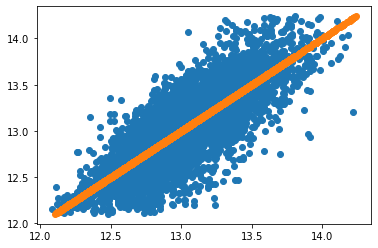

In [28]:
X5 = df5.drop(['price_log'], axis=1)
y5 = df5[['price_log']]
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5)
lr5 = LinearRegression()
lr5.fit(X5_train, y5_train)
y5_hat_train = lr5.predict(X5_train)
y5_hat_test = lr5.predict(X5_test)
train5_mse = mean_squared_error(y5_train, y5_hat_train)
test5_mse = mean_squared_error(y5_test, y5_hat_test)
print('LR5 R\u00b2:', lr5.score(X5_train, y5_train))
print('LR5 Train Mean Squared Error:', train5_mse)
print('LR5 Test Mean Squared Error:', test5_mse)
y5_test_pred = lr5.predict(X5_test)
plt.scatter(y5_test_pred, y5_test)
plt.scatter(y5_test, y5_test);

In [29]:
selector = RFE(lr5, n_features_to_select=4)
selector = selector.fit(X5, y5)
print(selector.support_)
display(X5)

[ True  True False False False  True False False False  True]


sqft_living_log  distance_from_bellevue_log  bedrooms  sqft_lot  \
0            -1.333015                   -0.779285         3 -0.235435   
1             0.859765                    0.080655         3 -0.185703   
3             0.096449                    0.207620         4 -0.255741   
4            -0.337804                   -0.570959         3 -0.159524   
6            -0.279718                    1.723071         3 -0.198917   
...                ...                         ...       ...       ...   
21592        -0.601273                   -0.002377         3 -0.376605   
21593         0.559301                    0.040426         4 -0.230343   
21594        -1.743495                   -1.625162         2 -0.369764   
21595        -0.475249                   -0.477664         3 -0.337337   
21596        -1.743495                   -1.624142         2 -0.378323   

       floors  waterfront  sqft_basement  yr_renovated  house_age  view_none  
0         1.0           0      -0.690797     -0.182976   0.548424        1.0  
1         2.0           0       0.291442      5.451907   0.684577        1.0  
3         1.0           0       1.543796     -0.182976   0.208042        1.0  
4         1.0           0      -0.690797     -0.182976  -0.506761        1.0  
6         2.0           0      -0.690797     -0.182976  -0.813105        1.0  
...       ...         ...            ...           ...        ...        ...  
21592     3.0           0      -0.690797     -0.182976  -1.289640        1.0  
21593     2.0           0      -0.690797     -0.182976  -1.425793        1.0  
21594     2.0           0      -0.690797     -0.182976  -1.289640        1.0  
21595     2.0           0      -0.690797     -0.182976  -1.085411        1.0  
21596     2.0           0      -0.690797     -0.182976  -1.255602        1.0  

[18705 rows x 10 columns]

> Selector selects sqft_living_log, distance_from_bellevue_log, waterfront, & view_none.

<b>Sixth Multiple Linear Regression Model</b>
\
Fifth model with only keeping selected columns.

LR6 R²: 0.5717866376305559
LR6 Train Mean Squared Error: 0.07798939005538293
LR6 Test Mean Squared Error: 0.08173331486415121


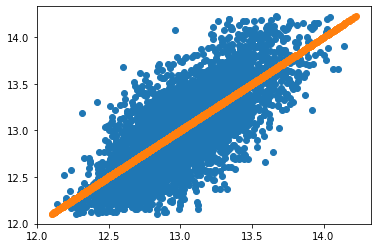

In [30]:
df6 = df5.copy()
X6 = df6[['sqft_living_log', 'distance_from_bellevue_log', 'waterfront', 'view_none']]
y6 = df6[['price_log']]
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6)
lr6 = LinearRegression()
lr6.fit(X6_train, y6_train)
y6_hat_train = lr6.predict(X6_train)
y6_hat_test = lr6.predict(X6_test)
train6_mse = mean_squared_error(y6_train, y6_hat_train)
test6_mse = mean_squared_error(y6_test, y6_hat_test)
print('LR6 R\u00b2:', lr6.score(X6_train, y6_train))
print('LR6 Train Mean Squared Error:', train6_mse)
print('LR6 Test Mean Squared Error:', test6_mse)
y6_test_pred = lr6.predict(X6_test)
plt.scatter(y6_test_pred, y6_test)
plt.scatter(y6_test, y6_test);

<b>Seventh Multiple Linear Regression Model</b>
\
???? model with several predictor variables scaled.

In [31]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X5, y5, verbose=True)
print('resulting features:')
print(result)

Add  floors                         with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  sqft_living_log                with p-value 0.0
Add  distance_from_bellevue_log     with p-value 0.0
Add  view_none                      with p-value 2.00099e-237
Add  house_age                      with p-value 1.91135e-145
Add  bedrooms                       with p-value 1.96101e-122
Add  sqft_lot                       with p-value 4.04509e-50
Add  waterfront                     with p-value 6.67717e-25
Add  yr_renovated                   with p-value 0.00422682
resulting features:
['floors', 'sqft_basement', 'sqft_living_log', 'distance_from_bellevue_log', 'view_none', 'house_age', 'bedrooms', 'sqft_lot', 'waterfront', 'yr_renovated']


LR7 R²: 0.615408636249096
LR7 Train Mean Squared Error: 0.07090187020262134
LR7 Test Mean Squared Error: 0.0716002256061957


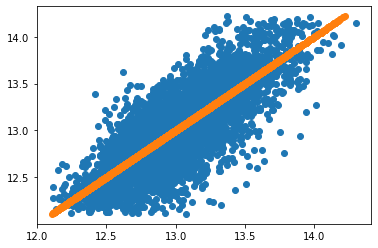

In [32]:
df7 = df6.copy()
X7 = df7[['sqft_living_log', 'distance_from_bellevue_log', 'view_none', 'bedrooms',
          'floors', 'house_age', 'sqft_lot', 'waterfront', 'sqft_basement', 'yr_renovated']]
y7 = df7[['price_log']]
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7)
lr7 = LinearRegression()
lr7.fit(X7_train, y7_train)
y7_hat_train = lr7.predict(X7_train)
y7_hat_test = lr7.predict(X7_test)
train7_mse = mean_squared_error(y7_train, y7_hat_train)
test7_mse = mean_squared_error(y7_test, y7_hat_test)
print('LR7 R\u00b2:', lr7.score(X7_train, y7_train))
print('LR7 Train Mean Squared Error:', train7_mse)
print('LR7 Test Mean Squared Error:', test7_mse)
y7_test_pred = lr7.predict(X7_test)
plt.scatter(y7_test_pred, y7_test)
plt.scatter(y7_test, y7_test);

## Conclusions

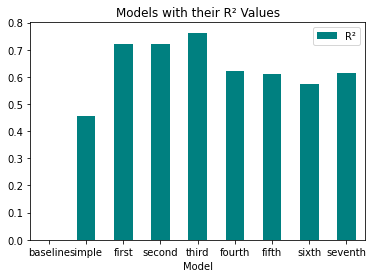

In [33]:
baseline = baseline.score(X_train, y_train)
simple = lr.score(X_train, y_train)
first = lr1.score(X1_train, y1_train)
second = lr2.score(X2_train, y2_train)
third = lr3.score(X3_train, y3_train)
fourth = lr4.score(X4_train, y4_train)
fifth = lr5.score(X5_train, y5_train)
sixth = lr6.score(X6_train, y6_train)
seventh = lr7.score(X7_train, y7_train)

barchart = pd.DataFrame({'Model':['baseline', 'simple', 'first', 'second', 'third', 'fourth', 'fifth', 'sixth', 'seventh'],
                         'R\u00b2':[baseline, simple, first, second, third, fourth, fifth, sixth, seventh]})
ax = barchart.plot.bar(x='Model', y='R\u00b2', rot=0, color='teal')
plt.title('Models with their R\u00b2 Values');